# Autoencoders

Autoencoders are an unsupervised technique from deep learning, built upon a framework of neural networks in two parts - an *encoder*, and a *decoder*.

The general principle is that data in $n$ dimensions is passed to a much smaller $k$-dimensional space with the encoder half, and decoded back to $n$-dimensional space in such a way that, in general, the decoded data are as close as possible to the input data.

By doing this, we can reduce data into a small number of dimensions, and still be able to produce very similar data later using on those dimensions.

This notebook contains an example using the MNIST dataset - a collection of 60,000 images of handwritten digits 0-9. It is powered by the Pytorch package, a framework for deep learning.

First we create the framework that our autoencoder will be built upon.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch import nn, optim
from torchvision import datasets, transforms

tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=tensor_transform
)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=100, shuffle=True)


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=2),
            nn.MaxPool2d(1),
            nn.Conv2d(4, 32, kernel_size=3, stride=2),
            nn.MaxPool2d(1),
            nn.Flatten(),
            nn.Linear(6 * 6 * 32, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 9),
            nn.ReLU(),
            nn.Linear(9, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 9),
            nn.ReLU(),
            nn.Linear(9, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 6 * 6 * 32),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(32, 6, 6)),
            nn.ConvTranspose2d(32, 4, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=3, stride=2, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

If you like, you can recreate your own model using the below cell - but it may take some time to run. This repository contains a pre-built model which will be loaded in a later cell.

The model provided reduces the $28\times28$ images into 2D.

In [ ]:
model = AutoEncoder()
loss_function = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-6)

epochs = 30
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for images, _ in loader:

        reconstructed = model(images)
        loss = loss_function(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

sns.lineplot(data=losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

We can visualise how the model works - in the below image, numbers on top are from the input dataset, and numbers below are what they look like after being encoded and decoded.

Note: if you have chosen to run the above cell and train your own model, you can comment out the top two lines in this cell. The three cells at the bottom of this notebook may also need adjusting.

1
5
4
6
0
8
4
5
4
7


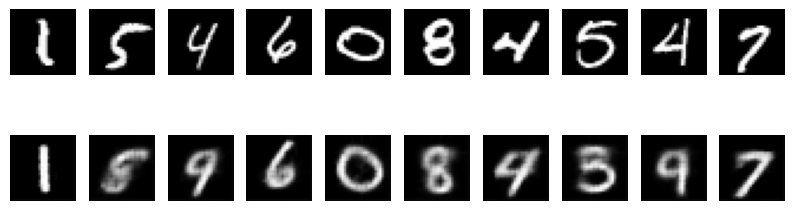

In [2]:
model = AutoEncoder()
model.load_state_dict(torch.load("../models/20250318_1914_convolutional_autoencoder_model.pth"))
model.eval()
dataiter = iter(loader)
images, targets = next(dataiter)

reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    print(targets[i].item())
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(
        reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap="gray"
    )
    axes[1, i].axis("off")
plt.show()

These are not perfect, but many of the digits in the training data are being remapped pretty well considering how ambitious our model is!

We can now encode all images into two dimensions and plot a sample of these to see if we can identify different clusters.

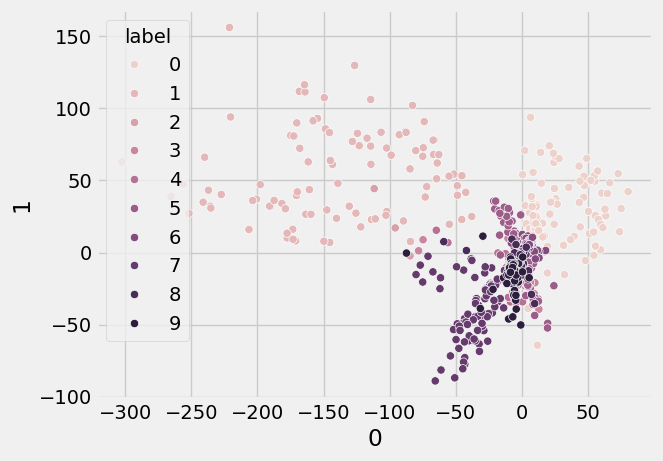

In [3]:
deconstructed_df = pd.DataFrame()
for images, targets in loader:
    deconstructed = model.encode(images)
    deconstructed_df = pd.concat(
        [
            deconstructed_df,
            pd.concat(
                [
                    pd.DataFrame(deconstructed.detach().numpy()),
                    pd.DataFrame({"label": targets.detach().numpy()}),
                ],
                axis=1,
            ),
        ],
        axis=0,
    )


plot_sample_df = pd.DataFrame()
for label in range(10):
    plot_sample_df = pd.concat(
        [
            plot_sample_df,
            deconstructed_df[deconstructed_df["label"] == label].sample(100),
        ],
        axis=0,
    )

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots()
sns.scatterplot(data=plot_sample_df, x=0, y=1, hue="label", legend="full")
h, l = ax.get_legend_handles_labels()
ax.legend(h, list(range(10)), title="label", loc="upper left")
plt.show()

The clusters above are not cleanly separable, but I think we can forgive that of a model attempting to transform 784D ($28\times28$) data into 2D!

Not only can we encode vectors in 784D space, we can now enter a pair of $x$, $y$ co-ordinates into our model's decoder, and create a brand new image that has never been seen before! Autoencoders form the foundation for generative artificial intelligence - if images can be transformed into random noise, like above, and then decoded, we can plug other random noise into the decoder and form images that are completely new.

Look at the cluster of 7s at the bottom. Let's take a point somewhere in the middle of this cluster, say $(-50, -75)$:

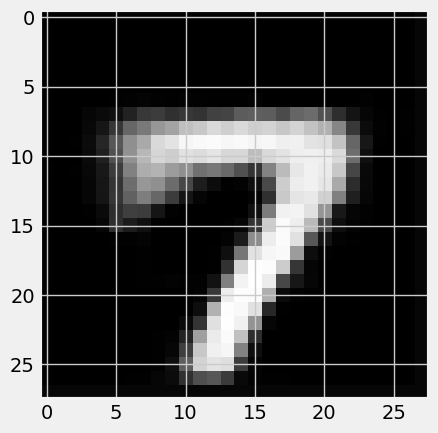

In [4]:
fig, ax = plt.subplots()
ax.imshow(
    model.decode(torch.tensor([[-50, -75]], dtype=torch.float))
    .detach()
    .numpy()
    .reshape(28, 28),
    cmap="gray",
)
plt.show()

The 7 above has never been seen before - it has been generated out of random noise in the form of two numbers! We can do this for other clusters - say the 0s in the top right.

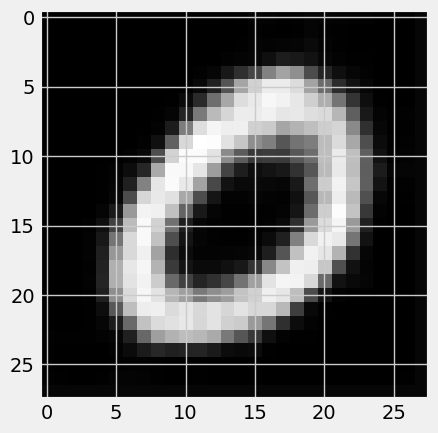

In [5]:
fig, ax = plt.subplots()
ax.imshow(
    model.decode(torch.tensor([[25, 40]], dtype=torch.float))
    .detach()
    .numpy()
    .reshape(28, 28),
    cmap="gray",
)
plt.show()

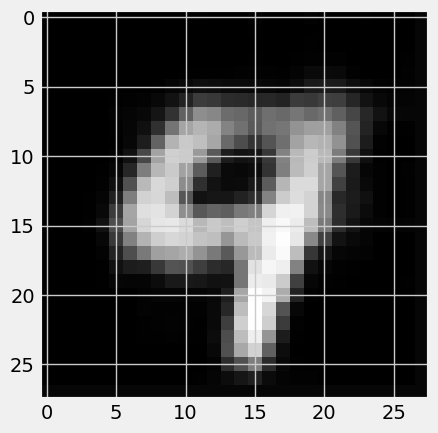

In [6]:
fig, ax = plt.subplots()
ax.imshow(
    model.decode(torch.tensor([[-10, -20]], dtype=torch.float))
    .detach()
    .numpy()
    .reshape(28, 28),
    cmap="gray",
)
plt.show()